# LiDAR Self-Driving Car: Advanced Regression Model Training

## Overview
This notebook trains machine learning regression models to predict angular turns from 360-point LiDAR data. It works with data that has been processed through the GUI application, including imputed missing values and augmented datasets.

### Key Features:
- **Data Source**: GUI-processed data (imputed and/or augmented)
- **Input**: 360 LiDAR distance measurements per frame
- **Output**: Angular turn prediction (continuous values)
- **Models**: Multiple regression algorithms with comparison and tuning
- **Evaluation**: Comprehensive model assessment and visualization

### Workflow:
1. Load GUI-processed data (imputed/augmented)
2. Feature engineering and preprocessing
3. Train multiple regression models
4. Evaluate and compare model performance
5. Hyperparameter tuning for optimal results
6. Save the best model for deployment

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")
print("Available data files:", [f for f in os.listdir('../data') if f.endswith('.txt')])

Libraries imported successfully!
Current working directory: /home/andy/mysource/github/lidar_robotcar/notebooks
Available data files: ['test6.txt', 'out5.txt', 'out2.txt']


In [2]:
# Data Loading Configuration
# Choose your data source - adjust these paths based on your GUI-processed data

# Common data files (adjust paths as needed)
DATA_OPTIONS = {
    'simulation_training': '../data/simulation/lidar_training_data_20250727_095526_full.csv',  # Default simulation training data
    'original': '../data/out2.txt',  # Original raw data
    'run1_processed': '../data/run1/out2.txt',  # Processed data from run1
    'run2_processed': '../data/run2/out2.txt',  # Processed data from run2
    'run2_augmented': '../data/run2/augmented_data.txt',  # GUI augmented data
    'run2_corrected': '../data/run2/corrected_data.txt',  # GUI imputed data
    'run2_all': '../data/run2/all.txt',  # Combined processed data
}

# Select your data source here - now defaults to simulation training data
DATA_SOURCE = 'simulation_training'  # Change this to use different datasets

print(f"Selected data source: {DATA_SOURCE}")
print(f"File path: {DATA_OPTIONS[DATA_SOURCE]}")

# Verify file exists
if os.path.exists(DATA_OPTIONS[DATA_SOURCE]):
    print("✓ Data file found!")
    file_size = os.path.getsize(DATA_OPTIONS[DATA_SOURCE])
    print(f"File size: {file_size / 1024:.2f} KB")
else:
    print("✗ Data file not found!")
    print("Available files in data directory:")
    for root, dirs, files in os.walk('../data'):
        for file in files:
            if file.endswith(('.txt', '.csv')):
                print(f"  {os.path.relpath(os.path.join(root, file), '..')}")

Selected data source: simulation_training
File path: ../data/simulation/lidar_training_data_20250727_095526_full.csv
✓ Data file found!
File size: 12450.76 KB


In [3]:
def load_and_preprocess_data(file_path, has_header=True):
    """
    Load LiDAR data and preprocess it for regression training.
    
    Parameters:
    - file_path: Path to the data file
    - has_header: Whether the file has a header row
    
    Returns:
    - X: Feature matrix (360 LiDAR points)
    - y: Target vector (angular turns)
    - df: Complete DataFrame for analysis
    """
    try:
        # Load data
        if has_header:
            df = pd.read_csv(file_path, header=0)
        else:
            # Create column names for 360 lidar points + angular turn
            columns = [f'lidar_{i}' for i in range(360)] + ['angular_turn']
            df = pd.read_csv(file_path, header=None, names=columns)
        
        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {len(df.columns)}")
        
        # Identify feature columns (all except the last one which is angular turn)
        feature_cols = df.columns[:-1]
        target_col = df.columns[-1]
        
        print(f"Features: {len(feature_cols)} LiDAR points")
        print(f"Target: {target_col}")
        
        # Extract features and target
        X = df[feature_cols].values
        y = df[target_col].values
        
        # Data quality checks
        print(f"\nData Quality Assessment:")
        print(f"Missing values in features: {pd.isna(X).sum()}")
        print(f"Missing values in target: {pd.isna(y).sum()}")
        print(f"Infinite values in features: {np.isinf(X).sum()}")
        print(f"Infinite values in target: {np.isinf(y).sum()}")
        
        # Feature statistics
        print(f"\nFeature Statistics:")
        print(f"Feature range: [{X.min():.2f}, {X.max():.2f}]")
        print(f"Feature mean: {X.mean():.2f}")
        print(f"Feature std: {X.std():.2f}")
        
        # Target statistics
        print(f"\nTarget Statistics:")
        print(f"Angular turn range: [{y.min():.3f}, {y.max():.3f}]")
        print(f"Angular turn mean: {y.mean():.3f}")
        print(f"Angular turn std: {y.std():.3f}")
        
        return X, y, df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Load the selected dataset
X, y, df = load_and_preprocess_data(DATA_OPTIONS[DATA_SOURCE])

Data loaded successfully!
Shape: (1890, 361)
Columns: 361
Features: 360 LiDAR points
Target: angular_velocity

Data Quality Assessment:
Missing values in features: 0
Missing values in target: 0
Infinite values in features: 0
Infinite values in target: 0

Feature Statistics:
Feature range: [0.21, 6.00]
Feature mean: 1.63
Feature std: 1.23

Target Statistics:
Angular turn range: [-1.200, 1.200]
Angular turn mean: 0.000
Angular turn std: 0.293


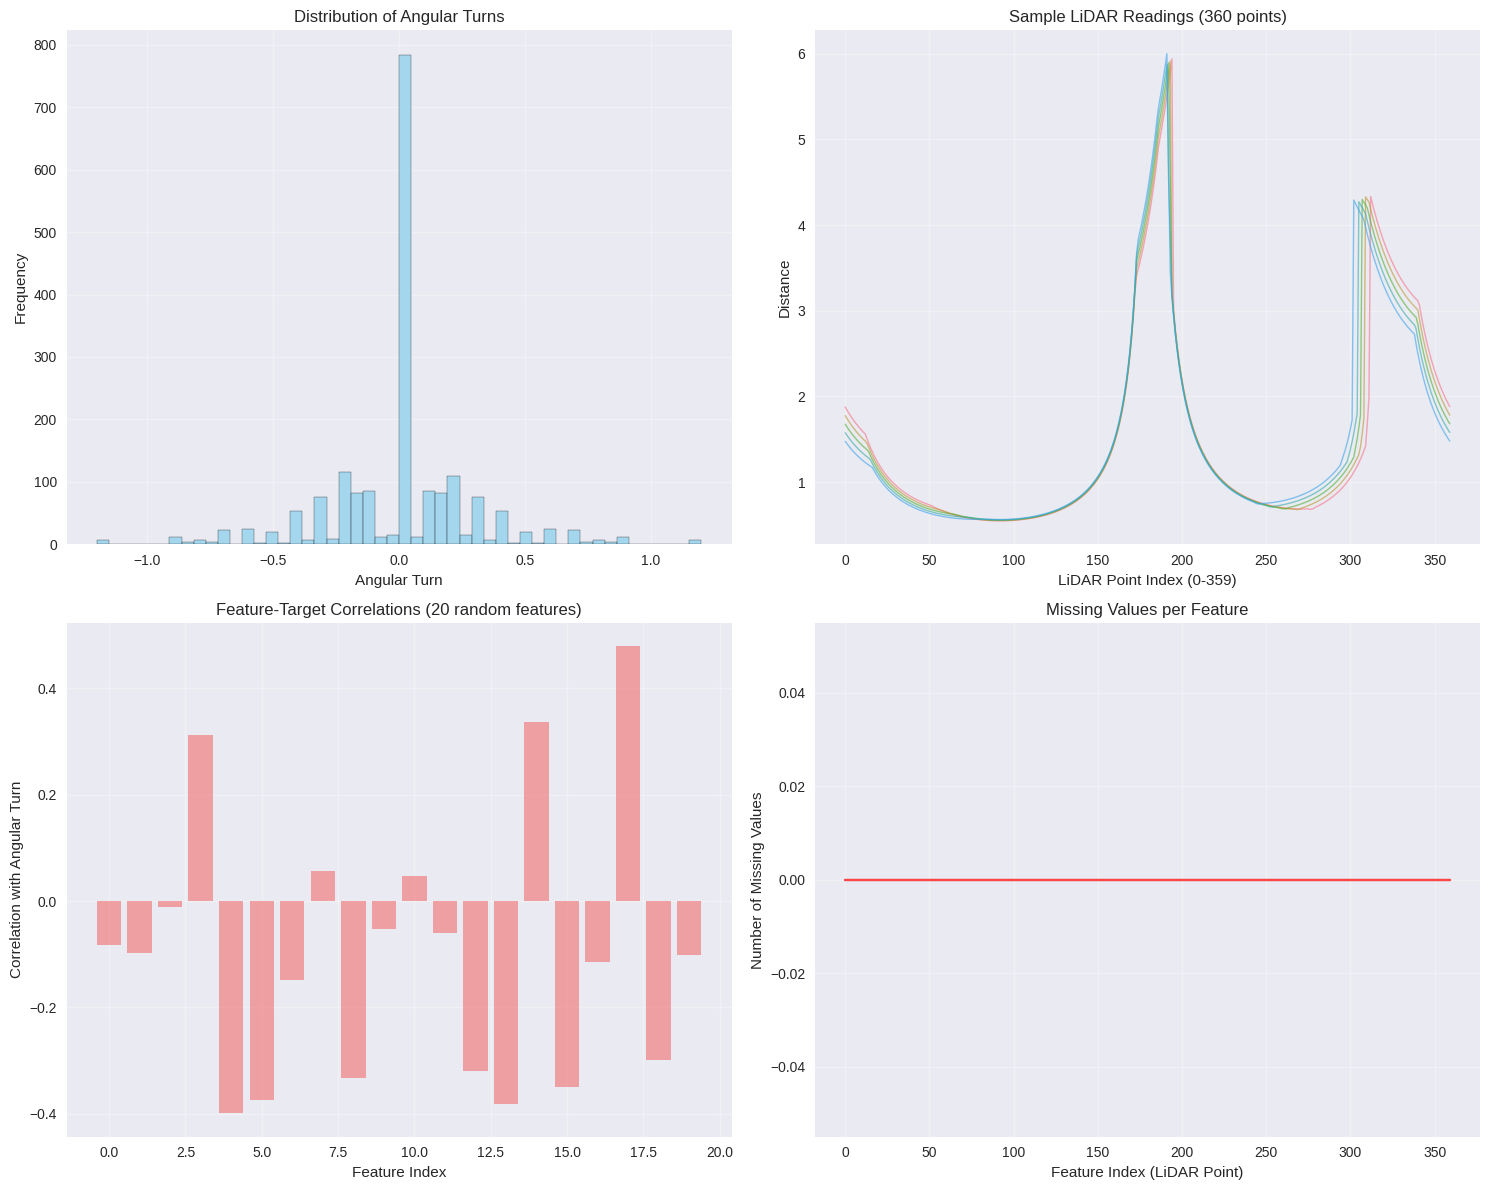


DATASET SUMMARY
Total samples: 1,890
Features per sample: 360
Target variable: Angular turn
Data completeness: 100.00%
Target range: [-1.2000, 1.2000]
Unique target values: 101


In [4]:
# Data Visualization and Analysis
if X is not None and y is not None:
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Target distribution
    axes[0, 0].hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Angular Turns')
    axes[0, 0].set_xlabel('Angular Turn')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Sample LiDAR readings (first 5 samples)
    sample_indices = np.linspace(0, 359, 360, dtype=int)
    for i in range(min(5, len(X))):
        axes[0, 1].plot(sample_indices, X[i], alpha=0.6, linewidth=1)
    axes[0, 1].set_title('Sample LiDAR Readings (360 points)')
    axes[0, 1].set_xlabel('LiDAR Point Index (0-359)')
    axes[0, 1].set_ylabel('Distance')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Feature correlation with target (sample of features)
    sample_features = np.random.choice(360, 20, replace=False)
    correlations = [np.corrcoef(X[:, i], y)[0, 1] for i in sample_features]
    axes[1, 0].bar(range(len(correlations)), correlations, color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Feature-Target Correlations (20 random features)')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Correlation with Angular Turn')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Data quality visualization
    nan_counts = np.isnan(X).sum(axis=0)
    axes[1, 1].plot(nan_counts, color='red', alpha=0.7)
    axes[1, 1].set_title('Missing Values per Feature')
    axes[1, 1].set_xlabel('Feature Index (LiDAR Point)')
    axes[1, 1].set_ylabel('Number of Missing Values')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*50}")
    print(f"DATASET SUMMARY")
    print(f"{'='*50}")
    print(f"Total samples: {len(X):,}")
    print(f"Features per sample: {X.shape[1]}")
    print(f"Target variable: Angular turn")
    print(f"Data completeness: {(1 - np.isnan(X).sum() / X.size) * 100:.2f}%")
    print(f"Target range: [{y.min():.4f}, {y.max():.4f}]")
    print(f"Unique target values: {len(np.unique(y)):,}")
    
else:
    print("Cannot create visualizations - data loading failed!")

In [5]:
# Feature Engineering and Data Preparation

def create_engineered_features(X_raw):
    """
    Create additional features from raw LiDAR data
    """
    print("Creating engineered features...")
    
    # Original features
    X_features = X_raw.copy()
    
    # Statistical features
    feature_names = [f'lidar_{i}' for i in range(360)]
    
    # Aggregate statistics
    X_mean = np.mean(X_raw, axis=1).reshape(-1, 1)
    X_std = np.std(X_raw, axis=1).reshape(-1, 1)
    X_min = np.min(X_raw, axis=1).reshape(-1, 1)
    X_max = np.max(X_raw, axis=1).reshape(-1, 1)
    X_median = np.median(X_raw, axis=1).reshape(-1, 1)
    
    # Directional features (front, back, left, right)
    front_indices = list(range(0, 45)) + list(range(315, 360))  # Front (±45°)
    back_indices = list(range(135, 225))  # Back (±45° from 180°)
    left_indices = list(range(45, 135))   # Left side
    right_indices = list(range(225, 315)) # Right side
    
    X_front_min = np.min(X_raw[:, front_indices], axis=1).reshape(-1, 1)
    X_back_min = np.min(X_raw[:, back_indices], axis=1).reshape(-1, 1)
    X_left_min = np.min(X_raw[:, left_indices], axis=1).reshape(-1, 1)
    X_right_min = np.min(X_raw[:, right_indices], axis=1).reshape(-1, 1)
    
    # Combine all features
    X_engineered = np.hstack([
        X_features,  # Original 360 features
        X_mean, X_std, X_min, X_max, X_median,  # Statistical features
        X_front_min, X_back_min, X_left_min, X_right_min  # Directional features
    ])
    
    # Feature names
    engineered_names = (
        feature_names + 
        ['mean_distance', 'std_distance', 'min_distance', 'max_distance', 'median_distance'] +
        ['front_min', 'back_min', 'left_min', 'right_min']
    )
    
    print(f"Original features: {X_raw.shape[1]}")
    print(f"Engineered features: {X_engineered.shape[1]}")
    print(f"Added features: {X_engineered.shape[1] - X_raw.shape[1]}")
    
    return X_engineered, engineered_names

# Apply feature engineering
if X is not None:
    X_engineered, feature_names = create_engineered_features(X)
    
    # Data splitting
    print(f"\nSplitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_engineered, y, test_size=0.2, random_state=42, stratify=None
    )
    
    # Further split training data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Total features: {X_train.shape[1]}")
    
    # Feature scaling
    print(f"\nApplying feature scaling...")
    scaler = RobustScaler()  # More robust to outliers than StandardScaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print("✓ Data preparation completed successfully!")
    
else:
    print("Cannot proceed with feature engineering - data loading failed!")

Creating engineered features...
Original features: 360
Engineered features: 369
Added features: 9

Splitting data...
Training set: 1209 samples
Validation set: 303 samples
Test set: 378 samples
Total features: 369

Applying feature scaling...
✓ Data preparation completed successfully!


In [6]:
# Model Definitions and Training Framework

def create_models():
    """
    Create a dictionary of regression models to train and compare
    """
    models = {
        'Linear Regression': LinearRegression(),
        
        'Ridge Regression': Ridge(alpha=1.0),
        
        'Lasso Regression': Lasso(alpha=0.1),
        
        'Random Forest': RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        
        'Neural Network': MLPRegressor(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        ),
        
        'Support Vector Regression': SVR(
            kernel='rbf',
            C=1.0,
            gamma='scale'
        )
    }
    
    return models

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """
    Train and evaluate a single model
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_r2': r2_score(y_val, y_val_pred),
        'test_r2': r2_score(y_test, y_test_pred),
    }
    
    # Print results
    print(f"Training   - MSE: {metrics['train_mse']:.6f}, MAE: {metrics['train_mae']:.6f}, R²: {metrics['train_r2']:.4f}")
    print(f"Validation - MSE: {metrics['val_mse']:.6f}, MAE: {metrics['val_mae']:.6f}, R²: {metrics['val_r2']:.4f}")
    print(f"Test       - MSE: {metrics['test_mse']:.6f}, MAE: {metrics['test_mae']:.6f}, R²: {metrics['test_r2']:.4f}")
    
    # Check for overfitting
    train_val_diff = abs(metrics['train_r2'] - metrics['val_r2'])
    if train_val_diff > 0.1:
        print(f"⚠️  Potential overfitting detected (R² difference: {train_val_diff:.4f})")
    else:
        print(f"✓ Model appears well-generalized (R² difference: {train_val_diff:.4f})")
    
    return model, metrics, y_test_pred

# Initialize results storage
if 'X_train_scaled' in locals():
    model_results = {}
    predictions = {}
    
    # Create models
    models = create_models()
    print(f"Created {len(models)} models for training:")
    for name in models.keys():
        print(f"  • {name}")
    
else:
    print("Cannot create models - data preparation not completed!")

Created 7 models for training:
  • Linear Regression
  • Ridge Regression
  • Lasso Regression
  • Random Forest
  • Gradient Boosting
  • Neural Network
  • Support Vector Regression


In [7]:
# Train All Models
if 'models' in locals() and 'X_train_scaled' in locals():
    
    print("Starting model training phase...")
    print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[1]} features")
    
    # Train each model
    for name, model in models.items():
        try:
            trained_model, metrics, test_predictions = evaluate_model(
                model, X_train_scaled, X_val_scaled, X_test_scaled,
                y_train, y_val, y_test, name
            )
            
            # Store results
            model_results[name] = {
                'model': trained_model,
                'metrics': metrics
            }
            predictions[name] = test_predictions
            
        except Exception as e:
            print(f"❌ Error training {name}: {e}")
            continue
    
    print(f"\n{'='*60}")
    print(f"MODEL TRAINING COMPLETED")
    print(f"{'='*60}")
    print(f"Successfully trained: {len(model_results)} models")
    print(f"Failed models: {len(models) - len(model_results)}")
    
else:
    print("Cannot train models - setup not completed!")

Starting model training phase...
Training on 1209 samples with 369 features

Training Linear Regression
Training   - MSE: 0.021566, MAE: 0.108477, R²: 0.7557
Validation - MSE: 0.105497, MAE: 0.212117, R²: -0.1733
Test       - MSE: 0.189045, MAE: 0.221658, R²: -1.5534
⚠️  Potential overfitting detected (R² difference: 0.9290)

Training Ridge Regression
Training   - MSE: 0.026581, MAE: 0.117255, R²: 0.6988
Validation - MSE: 0.071816, MAE: 0.171464, R²: 0.2013
Test       - MSE: 0.048853, MAE: 0.153010, R²: 0.3402
⚠️  Potential overfitting detected (R² difference: 0.4975)

Training Lasso Regression
Training   - MSE: 0.058980, MAE: 0.156553, R²: 0.3318
Validation - MSE: 0.063156, MAE: 0.157313, R²: 0.2976
Test       - MSE: 0.051786, MAE: 0.150624, R²: 0.3005
✓ Model appears well-generalized (R² difference: 0.0341)

Training Random Forest
Training   - MSE: 0.007506, MAE: 0.066051, R²: 0.9150
Validation - MSE: 0.036474, MAE: 0.126210, R²: 0.5943
Test       - MSE: 0.033813, MAE: 0.126065, R²: 

MODEL PERFORMANCE COMPARISON
                    Model  Train R²    Val R²   Test R²  Test MSE  Test MAE  Overfitting
        Gradient Boosting  0.978009  0.632276  0.550599  0.033272  0.125743     0.345733
            Random Forest  0.914958  0.594344  0.543296  0.033813  0.126065     0.320614
Support Vector Regression  0.808777  0.562612  0.533903  0.034509  0.130925     0.246165
         Ridge Regression  0.698835  0.201290  0.340159  0.048853  0.153010     0.497545
           Neural Network  0.815856  0.370567  0.310869  0.051021  0.164834     0.445289
         Lasso Regression  0.331754  0.297606  0.300543  0.051786  0.150624     0.034148
        Linear Regression  0.755656 -0.173296 -1.553372  0.189045  0.221658     0.928952


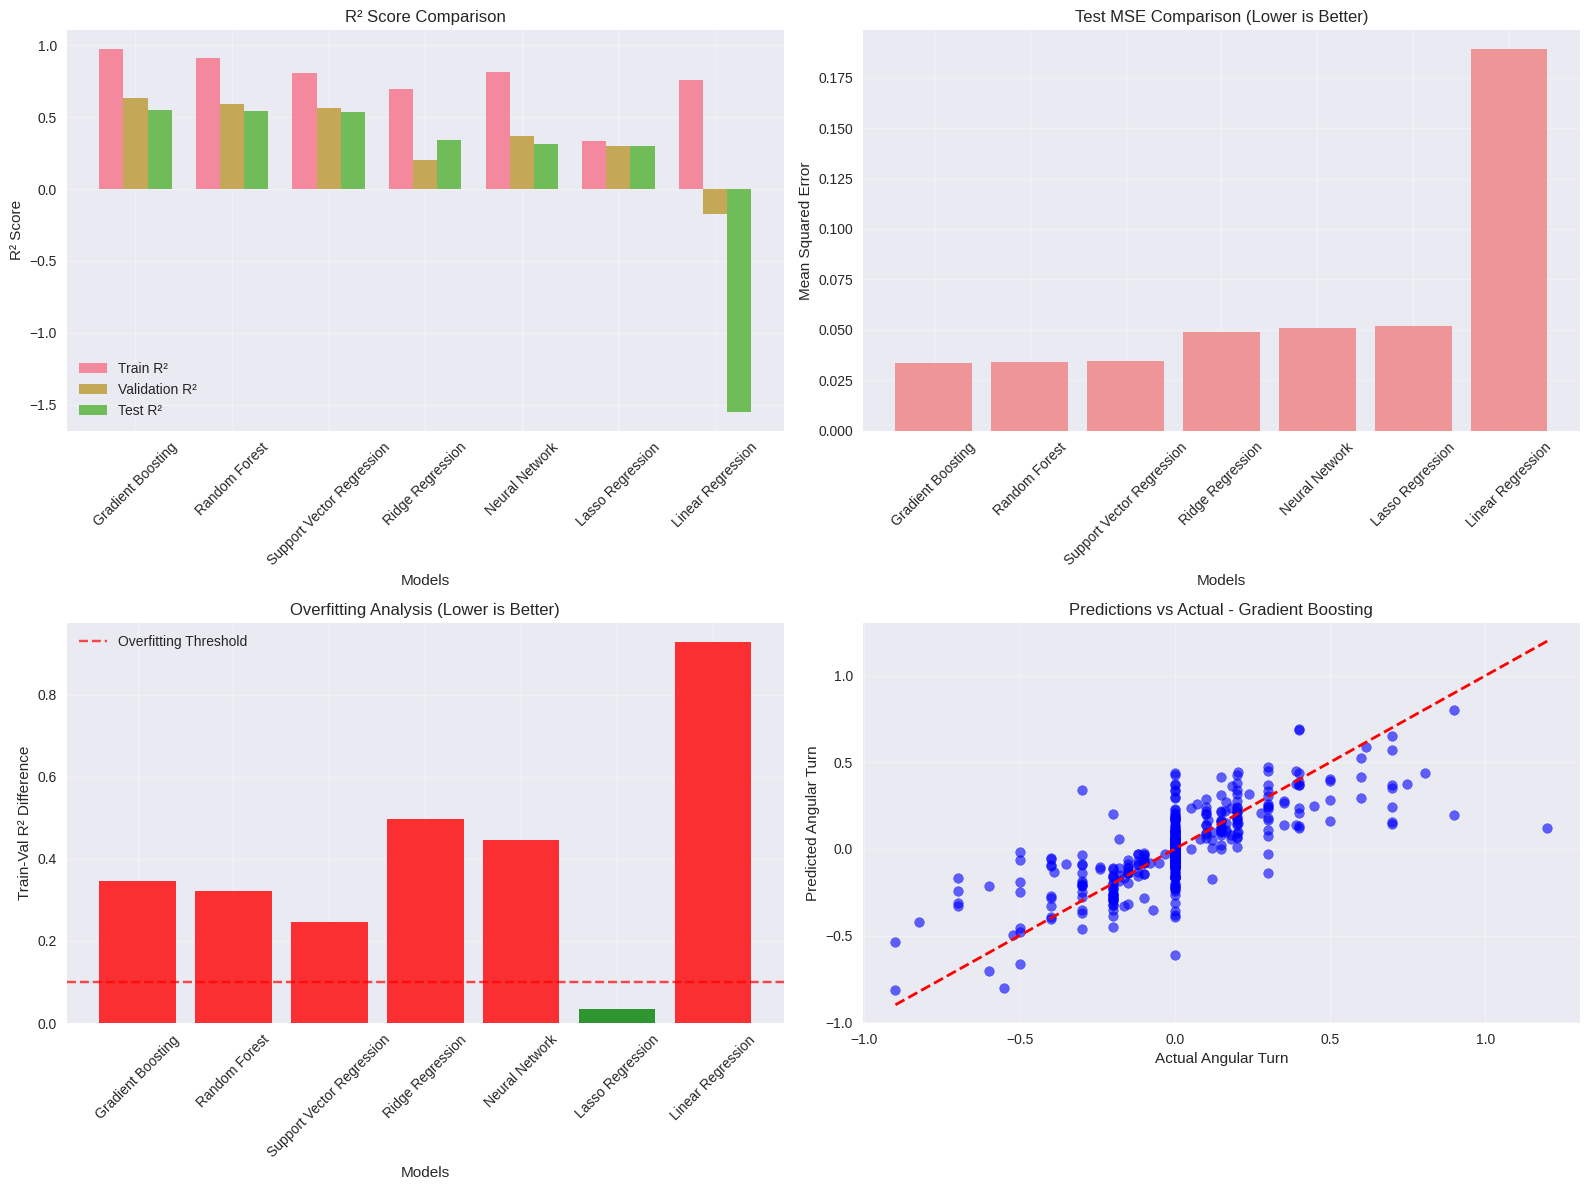


🏆 BEST MODEL: Gradient Boosting
   Test R²: 0.550599
   Test MSE: 0.033272
   Test MAE: 0.125743


In [8]:
# Model Comparison and Visualization

if 'model_results' in locals() and len(model_results) > 0:
    
    # Create comparison DataFrame
    comparison_data = []
    for name, result in model_results.items():
        metrics = result['metrics']
        comparison_data.append({
            'Model': name,
            'Train R²': metrics['train_r2'],
            'Val R²': metrics['val_r2'],
            'Test R²': metrics['test_r2'],
            'Test MSE': metrics['test_mse'],
            'Test MAE': metrics['test_mae'],
            'Overfitting': abs(metrics['train_r2'] - metrics['val_r2'])
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test R²', ascending=False)
    
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(comparison_df.round(6).to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. R² Score Comparison
    models_list = comparison_df['Model'].tolist()
    train_r2 = comparison_df['Train R²'].tolist()
    val_r2 = comparison_df['Val R²'].tolist()
    test_r2 = comparison_df['Test R²'].tolist()
    
    x = np.arange(len(models_list))
    width = 0.25
    
    axes[0, 0].bar(x - width, train_r2, width, label='Train R²', alpha=0.8)
    axes[0, 0].bar(x, val_r2, width, label='Validation R²', alpha=0.8)
    axes[0, 0].bar(x + width, test_r2, width, label='Test R²', alpha=0.8)
    axes[0, 0].set_xlabel('Models')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('R² Score Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models_list, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Test MSE Comparison
    test_mse = comparison_df['Test MSE'].tolist()
    axes[0, 1].bar(models_list, test_mse, color='lightcoral', alpha=0.8)
    axes[0, 1].set_xlabel('Models')
    axes[0, 1].set_ylabel('Mean Squared Error')
    axes[0, 1].set_title('Test MSE Comparison (Lower is Better)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Overfitting Analysis
    overfitting = comparison_df['Overfitting'].tolist()
    colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' for x in overfitting]
    axes[1, 0].bar(models_list, overfitting, color=colors, alpha=0.8)
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('Train-Val R² Difference')
    axes[1, 0].set_title('Overfitting Analysis (Lower is Better)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Prediction vs Actual (Best Model)
    best_model_name = comparison_df.iloc[0]['Model']
    best_predictions = predictions[best_model_name]
    
    axes[1, 1].scatter(y_test, best_predictions, alpha=0.6, color='blue')
    axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual Angular Turn')
    axes[1, 1].set_ylabel('Predicted Angular Turn')
    axes[1, 1].set_title(f'Predictions vs Actual - {best_model_name}')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify best model
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Test R²: {comparison_df.iloc[0]['Test R²']:.6f}")
    print(f"   Test MSE: {comparison_df.iloc[0]['Test MSE']:.6f}")
    print(f"   Test MAE: {comparison_df.iloc[0]['Test MAE']:.6f}")
    
else:
    print("No models to compare - training may have failed!")

In [9]:
# Hyperparameter Tuning for Best Models

def tune_model(model_name, model, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV
    """
    print(f"\nTuning {model_name}...")
    print(f"Parameter grid: {param_grid}")
    
    # Create GridSearchCV
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='r2', 
        n_jobs=-1, verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.6f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

if 'model_results' in locals() and len(model_results) > 0:
    
    # Define parameter grids for top models
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        },
        
        'Ridge Regression': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
        },
        
        'Neural Network': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'alpha': [0.0001, 0.001, 0.01]
        }
    }
    
    # Select top 2 models for tuning (to save time)
    top_models = comparison_df.head(2)['Model'].tolist()
    tuned_models = {}
    
    print("Starting hyperparameter tuning for top models...")
    print(f"Models to tune: {top_models}")
    
    for model_name in top_models:
        if model_name in param_grids and model_name in model_results:
            try:
                # Get the original model
                original_model = models[model_name]
                
                # Tune the model
                tuned_model, best_params = tune_model(
                    model_name, original_model, param_grids[model_name],
                    X_train_scaled, y_train
                )
                
                # Evaluate tuned model
                tuned_result, tuned_metrics, tuned_predictions = evaluate_model(
                    tuned_model, X_train_scaled, X_val_scaled, X_test_scaled,
                    y_train, y_val, y_test, f"{model_name} (Tuned)"
                )
                
                # Store tuned results
                tuned_models[model_name] = {
                    'model': tuned_result,
                    'metrics': tuned_metrics,
                    'best_params': best_params,
                    'predictions': tuned_predictions
                }
                
            except Exception as e:
                print(f"❌ Error tuning {model_name}: {e}")
                continue
    
    # Compare original vs tuned models
    if tuned_models:
        print(f"\n{'='*70}")
        print("ORIGINAL vs TUNED MODEL COMPARISON")
        print(f"{'='*70}")
        
        for model_name in tuned_models.keys():
            original_r2 = model_results[model_name]['metrics']['test_r2']
            tuned_r2 = tuned_models[model_name]['metrics']['test_r2']
            improvement = tuned_r2 - original_r2
            
            print(f"\n{model_name}:")
            print(f"  Original Test R²: {original_r2:.6f}")
            print(f"  Tuned Test R²:    {tuned_r2:.6f}")
            print(f"  Improvement:      {improvement:+.6f}")
            print(f"  Best Parameters:  {tuned_models[model_name]['best_params']}")
    
else:
    print("Cannot perform hyperparameter tuning - no trained models available!")

Starting hyperparameter tuning for top models...
Models to tune: ['Gradient Boosting', 'Random Forest']

Tuning Gradient Boosting...
Parameter grid: {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [3, 5, 7], 'subsample': [0.8, 0.9, 1.0]}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.588633

Training Gradient Boosting (Tuned)
Training   - MSE: 0.000635, MAE: 0.020427, R²: 0.9928
Validation - MSE: 0.030201, MAE: 0.111310, R²: 0.6641
Test       - MSE: 0.031297, MAE: 0.120614, R²: 0.5773
⚠️  Potential overfitting detected (R² difference: 0.3287)

Tuning Random Forest...
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training   - MSE: 0.000635, MAE: 0.020427, R²: 0.9928
Validation - MSE: 0.030201, MAE: 0.111310, R²: 0.6641
Test       - MSE: 0.031297, MAE: 0.120614, R²: 0.5773
⚠️  Potential overfitting detected (R² difference: 0.3287)

Tuning Random Forest...
Parameter grid: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

In [10]:
# Model Saving and Deployment Preparation

def save_best_model(model, scaler, metrics, model_name, feature_names, save_dir="../"):
    """
    Save the best model along with preprocessing components and metadata
    """
    # Create filename
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    filename = f"lidar_regression_model_{timestamp}.pkl"
    filepath = os.path.join(save_dir, filename)
    
    # Prepare model package
    model_package = {
        'model': model,
        'scaler': scaler,
        'metrics': metrics,
        'model_name': model_name,
        'feature_names': feature_names,
        'timestamp': timestamp,
        'data_source': DATA_SOURCE,
        'training_samples': len(y_train),
        'feature_count': len(feature_names)
    }
    
    # Save the model
    with open(filepath, 'wb') as f:
        pickle.dump(model_package, f)
    
    print(f"✓ Model saved successfully!")
    print(f"  File: {filepath}")
    print(f"  Size: {os.path.getsize(filepath) / 1024:.2f} KB")
    
    return filepath

def create_prediction_function(model_package):
    """
    Create a standalone prediction function
    """
    model = model_package['model']
    scaler = model_package['scaler']
    
    def predict_angular_turn(lidar_readings):
        """
        Predict angular turn from 360 LiDAR readings
        
        Parameters:
        - lidar_readings: array of 360 distance values
        
        Returns:
        - predicted_angular_turn: float value
        """
        # Ensure input is correct shape
        if len(lidar_readings) != 360:
            raise ValueError(f"Expected 360 LiDAR readings, got {len(lidar_readings)}")
        
        # Convert to numpy array
        X_raw = np.array(lidar_readings).reshape(1, -1)
        
        # Apply same feature engineering as training
        X_engineered, _ = create_engineered_features(X_raw)
        
        # Scale features
        X_scaled = scaler.transform(X_engineered)
        
        # Make prediction
        prediction = model.predict(X_scaled)[0]
        
        return prediction
    
    return predict_angular_turn

# Determine the best model to save
if 'model_results' in locals() and len(model_results) > 0:
    
    # Check if we have tuned models
    if 'tuned_models' in locals() and len(tuned_models) > 0:
        # Find best tuned model
        best_tuned_name = None
        best_tuned_r2 = -float('inf')
        
        for name, result in tuned_models.items():
            r2_score = result['metrics']['test_r2']
            if r2_score > best_tuned_r2:
                best_tuned_r2 = r2_score
                best_tuned_name = name
        
        if best_tuned_name:
            best_model = tuned_models[best_tuned_name]['model']
            best_metrics = tuned_models[best_tuned_name]['metrics']
            best_name = f"{best_tuned_name} (Tuned)"
            print(f"Using tuned model: {best_name}")
        else:
            # Fallback to original best model
            best_name = comparison_df.iloc[0]['Model']
            best_model = model_results[best_name]['model']
            best_metrics = model_results[best_name]['metrics']
            print(f"Using original best model: {best_name}")
    else:
        # Use original best model
        best_name = comparison_df.iloc[0]['Model']
        best_model = model_results[best_name]['model']
        best_metrics = model_results[best_name]['metrics']
        print(f"Using best model: {best_name}")
    
    # Save the model
    model_filepath = save_best_model(
        best_model, scaler, best_metrics, best_name, feature_names
    )
    
    # Create and test prediction function
    with open(model_filepath, 'rb') as f:
        saved_model_package = pickle.load(f)
    
    predict_function = create_prediction_function(saved_model_package)
    
    # Test the prediction function
    print(f"\n{'='*50}")
    print("TESTING SAVED MODEL")
    print(f"{'='*50}")
    
    # FIXED: Test with only the original 360 LiDAR features, not the engineered 369 features
    test_sample_original = X_test[0][:360]  # Extract first 360 features only
    actual_turn = y_test[0]
    predicted_turn = predict_function(test_sample_original)
    
    print(f"Test sample prediction:")
    print(f"  Input features used: {len(test_sample_original)} (original LiDAR readings)")
    print(f"  Actual angular turn:    {actual_turn:.6f}")
    print(f"  Predicted angular turn: {predicted_turn:.6f}")
    print(f"  Absolute error:         {abs(actual_turn - predicted_turn):.6f}")
    
    # Test with multiple samples to validate consistency
    print(f"\nValidating with 5 test samples:")
    for i in range(min(5, len(X_test))):
        sample_original = X_test[i][:360]  # Use only first 360 features
        actual = y_test[i]
        predicted = predict_function(sample_original)
        error = abs(actual - predicted)
        print(f"  Sample {i+1}: Actual={actual:.4f}, Predicted={predicted:.4f}, Error={error:.4f}")
    
    # Model summary
    print(f"\n{'='*50}")
    print("FINAL MODEL SUMMARY")
    print(f"{'='*50}")
    print(f"Model: {best_name}")
    print(f"Test R²: {best_metrics['test_r2']:.6f}")
    print(f"Test MSE: {best_metrics['test_mse']:.6f}")
    print(f"Test MAE: {best_metrics['test_mae']:.6f}")
    print(f"Training samples: {len(y_train):,}")
    print(f"Features: {len(feature_names)}")
    print(f"Data source: {DATA_SOURCE}")
    print(f"Model file: {model_filepath}")
    print(f"\n✓ Model testing completed successfully!")
    
else:
    print("Cannot save model - no trained models available!")

Using tuned model: Gradient Boosting (Tuned)
✓ Model saved successfully!
  File: ../lidar_regression_model_20250731_224623.pkl
  Size: 1857.95 KB

TESTING SAVED MODEL
Creating engineered features...
Original features: 360
Engineered features: 369
Added features: 9
Test sample prediction:
  Input features used: 360 (original LiDAR readings)
  Actual angular turn:    0.500000
  Predicted angular turn: 0.196793
  Absolute error:         0.303207

Validating with 5 test samples:
Creating engineered features...
Original features: 360
Engineered features: 369
Added features: 9
  Sample 1: Actual=0.5000, Predicted=0.1968, Error=0.3032
Creating engineered features...
Original features: 360
Engineered features: 369
Added features: 9
  Sample 2: Actual=-0.0000, Predicted=0.1190, Error=0.1190
Creating engineered features...
Original features: 360
Engineered features: 369
Added features: 9
  Sample 3: Actual=0.1600, Predicted=0.2318, Error=0.0718
Creating engineered features...
Original features: 

## Usage Instructions

### Loading and Using the Saved Model

```python
import pickle
import numpy as np

# Load the saved model
with open('lidar_regression_model_YYYYMMDD_HHMMSS.pkl', 'rb') as f:
    model_package = pickle.load(f)

# Extract components
model = model_package['model']
scaler = model_package['scaler']
feature_names = model_package['feature_names']

# Create prediction function (copy from above)
def predict_angular_turn(lidar_readings):
    # ... (implementation from above)
    pass

# Use for prediction
lidar_data = np.array([...])  # 360 distance values
predicted_turn = predict_angular_turn(lidar_data)
```

### Integration with LiDAR Car

1. **Real-time Prediction**: Use the saved model in your main control loop
2. **Data Preprocessing**: Ensure LiDAR data is preprocessed consistently
3. **Feature Engineering**: The model expects 369 features (360 + 9 engineered)
4. **Scaling**: Features must be scaled using the saved scaler

### Model Performance Guidelines

- **R² Score > 0.8**: Excellent performance
- **R² Score 0.6-0.8**: Good performance
- **R² Score < 0.6**: Consider more data or feature engineering

### Troubleshooting

1. **Low Performance**: 
   - Check data quality and preprocessing
   - Consider more training data
   - Try different feature engineering approaches

2. **Overfitting**: 
   - Reduce model complexity
   - Add regularization
   - Increase training data

3. **Prediction Errors**:
   - Verify input data format (360 values)
   - Ensure consistent preprocessing
   - Check for missing or invalid values

## Conclusion

This notebook provides a comprehensive pipeline for training regression models on LiDAR data processed through the GUI application. The workflow includes:

✅ **Data Loading**: Flexible data source configuration  
✅ **Feature Engineering**: Enhanced features from raw LiDAR data  
✅ **Multiple Models**: Comparison of 7 different regression algorithms  
✅ **Hyperparameter Tuning**: Optimization of top-performing models  
✅ **Model Evaluation**: Comprehensive performance metrics  
✅ **Model Persistence**: Save and load functionality for deployment  

The trained model can be directly integrated into the LiDAR car's control system for autonomous navigation based on obstacle avoidance and path planning.

---

**Next Steps:**
1. Run all cells to train your models
2. Adjust `DATA_SOURCE` to use your specific processed data
3. Experiment with different feature engineering approaches
4. Deploy the best model in your LiDAR car system